# Nortek AD2CP Processing, Testing, and Data Exploration

jgradone@marine.rutgers.edu     01/11/2022      Initial<br>
jgradone@marine.rutgers.edu     09/15/2025      Edited after changes to be more package-like

**This Jupyter Notebook is intended to:**<br>
1) Read glider data frome ERDDAP <br>
2) Read in AD2CP data processed to NetCDFs using the Nortek MIDAS software as an xarray DataSet and combine all into one massive DataSet <br>
3) Pull out just one glider segment (based on a unique file name) and the corresponding dead-reckoned depth average current. Use the start and end times to subset the AD2CP data <br>
4) Correct for local speed of sound <br>
5) QAQC AD2CP data <br>
6) Correct beams to level true-depth <br>
7) Bin map AD2CP data <br>
8) AD2CP Coordinate transformation from beam to XYZ to ENU <br>
9) Least squares linear inversion on ADCP velocities referenced to true ocean velocity through a depth averaged urrent constraint <br>
10) Save output from each segment<br>


*Details/comments on what the functions are actually doing in the source code*

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import slocum_ad2cp


## Step 1: Load glider data

In [ ]:
ds_id = 'ru29-20240419T1430-trajectory-raw-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time','source_file', 'm_water_vx', 'm_water_vy', 'm_heading','m_gps_mag_var']
gdf = slocum_ad2cp.get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)
## Convert magnetic variation and heading to degrees
gdf['m_gps_mag_var'] = np.rad2deg(gdf['m_gps_mag_var'].values)
gdf['m_heading'] = np.rad2deg(gdf['m_heading'].values)
## Correct heading for magnetic variation
gdf['m_heading'] = gdf.m_heading-np.nanmean(gdf.m_gps_mag_var)
gdf


,depth,latitude,longitude,time,source_file,m_water_vx,m_water_vy,m_heading,m_gps_mag_var
0,0.000000,17.779262,-67.057948,2024-04-19T14:30:28Z,ru29-2024-109-2-0-dbd(06930000),NaN,NaN,NaN,NaN
1,NaN,17.779262,-67.057948,2024-04-19T14:30:31Z,ru29-2024-109-2-0-dbd(06930000),0.0,0.0,130.305985,12.40001
2,0.000000,17.779262,-67.057948,2024-04-19T14:30:32Z,ru29-2024-109-2-0-dbd(06930000),NaN,NaN,NaN,NaN
3,NaN,17.779262,-67.057948,2024-04-19T14:31:29Z,ru29-2024-109-2-0-dbd(06930000),0.0,0.0,130.305985,12.40001
4,NaN,17.779350,-67.057945,2024-04-19T14:31:49Z,ru29-2024-109-2-0-dbd(06930000),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
7446400,0.099413,15.649022,-68.998793,2024-07-02T09:09:13Z,ru29-2024-182-1-9-dbd(07060009),NaN,NaN,NaN,NaN
7446401,0.089471,15.649022,-68.998793,2024-07-02T09:09:15Z,ru29-2024-182-1-9-dbd(07060009),NaN,NaN,NaN,NaN
7446402,-0.049706,15.649022,-68.998793,2024-07-02T09:09:17Z,ru29-2024-182-1-9-dbd(07060009),NaN,NaN,NaN,NaN
7446403,-0.019883,15.649022,-68.998793,2024-07-02T09:09:19Z,ru29-2024-182-1-9-dbd(07060009),NaN,NaN,NaN,NaN


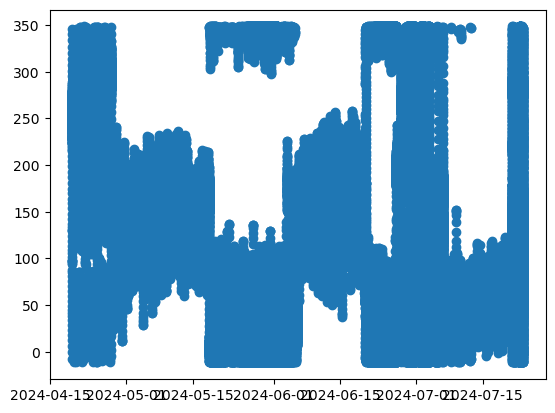

In [36]:
plt.scatter(pd.to_datetime(gdf.time),gdf.m_heading)

## Step 2: Load in AD2CP data frame

In [7]:
#file = "../raw_data/RU29_Test_AD2CP_1.nc"
#path='../data/ad2cp/'

path = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/RU29_69W/data/ad2cp/'
files = np.sort(glob.glob(path+'*.nc'))
tot_ad2cp = slocum_ad2cp.load_ad2cp(files,mean_lat=15)
tot_ad2cp


/Users/joegradone/anaconda3/envs/slocum_ad2cp/lib/python3.11/site-packages/slocum_ad2cp/make_dataset.py:853: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(
/Users/joegradone/anaconda3/envs/slocum_ad2cp/lib/python3.11/site-packages/slocum_ad2cp/make_dataset.py:853: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(
/Users/joegradone/anaconda3/envs/slocum_ad2cp/lib/python3.11/site-packages/slocum_ad2cp/make_dataset.py:853: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(
/

<xarray.Dataset> Size: 1GB
Dimensions:                    (time: 1152490, VelocityRange: 15,
                                CorrelationRange: 15, AmplitudeRange: 15,
                                Physicalbeam_dim: 4)
Coordinates:
  * time                       (time) datetime64[ns] 9MB 2024-04-19T14:32:13....
  * VelocityRange              (VelocityRange) float32 60B 2.2 4.2 ... 28.2 30.2
  * CorrelationRange           (CorrelationRange) float32 60B 2.2 4.2 ... 30.2
  * AmplitudeRange             (AmplitudeRange) float32 60B 2.2 4.2 ... 30.2
Dimensions without coordinates: Physicalbeam_dim
Data variables: (12/43)
    VelocityBeam1              (VelocityRange, time) float32 69MB dask.array<chunksize=(15, 80990), meta=np.ndarray>
    VelocityBeam2              (VelocityRange, time) float32 69MB dask.array<chunksize=(15, 80990), meta=np.ndarray>
    VelocityBeam3              (VelocityRange, time) float32 69MB dask.array<chunksize=(15, 80990), meta=np.ndarray>
    VelocityBeam4              (VelocityRange, time) float32 69MB dask.array<chunksize=(15, 80990), meta=np.ndarray>
    CorrelationBeam1           (CorrelationRange, time) float32 69MB dask.array<chunksize=(15, 80990), meta=np.ndarray>
    CorrelationBeam2           (CorrelationRange, time) float32 69MB dask.array<chunksize=(15, 80990), meta=np.ndarray>
    ...                         ...
    EnsembleCount              (time) float64 9MB dask.array<chunksize=(80990,), meta=np.ndarray>
    WaterTemperature           (time) float32 5MB dask.array<chunksize=(80990,), meta=np.ndarray>
    Heading                    (time) float32 5MB dask.array<chunksize=(80990,), meta=np.ndarray>
    Pitch                      (time) float32 5MB dask.array<chunksize=(80990,), meta=np.ndarray>
    Roll                       (time) float32 5MB dask.array<chunksize=(80990,), meta=np.ndarray>
    Depth                      (time) float64 9MB 0.85 0.9305 ... 0.8251 0.8928
Attributes: (12/350)
    instrumentOffsetTimeMatlab_description:       Offset from instrument time...
    File_ins_runTime:                             442996000.0
    File_ins_runTime_description:                 Length of time data was col...
    File_ins_name:                                AD2CPRaw
    File_ins_name_description:                    Name of instrument
    File_ins_typeName:                            
    ...                                           ...
    instrumentOffsetTime:                         0.0
    instrumentOffsetTime_description:             Offset from instrument time...
    timeZoneOffset:                               0
    timeZoneOffset_description:                   Offset of platform local ti...
    instrumentOffsetTimeMatlab:                   0.0
    exportRevision:                               4489

## Step 3: Soft Iron Magnetic Correction (pitch-dependent)
Best to do this on the entire dataset first

In [8]:
tot_ad2cp = slocum_ad2cp.correct_ad2cp_heading(tot_ad2cp)

/Users/joegradone/anaconda3/envs/slocum_ad2cp/lib/python3.11/site-packages/slocum_ad2cp/make_dataset.py:959: RuntimeWarning: invalid value encountered in sqrt
  radii = np.sqrt(1. / evals)
/Users/joegradone/anaconda3/envs/slocum_ad2cp/lib/python3.11/site-packages/slocum_ad2cp/make_dataset.py:1094: RuntimeWarning: invalid value encountered in multiply
  CorrectedHeading = np.empty_like(head) * np.nan


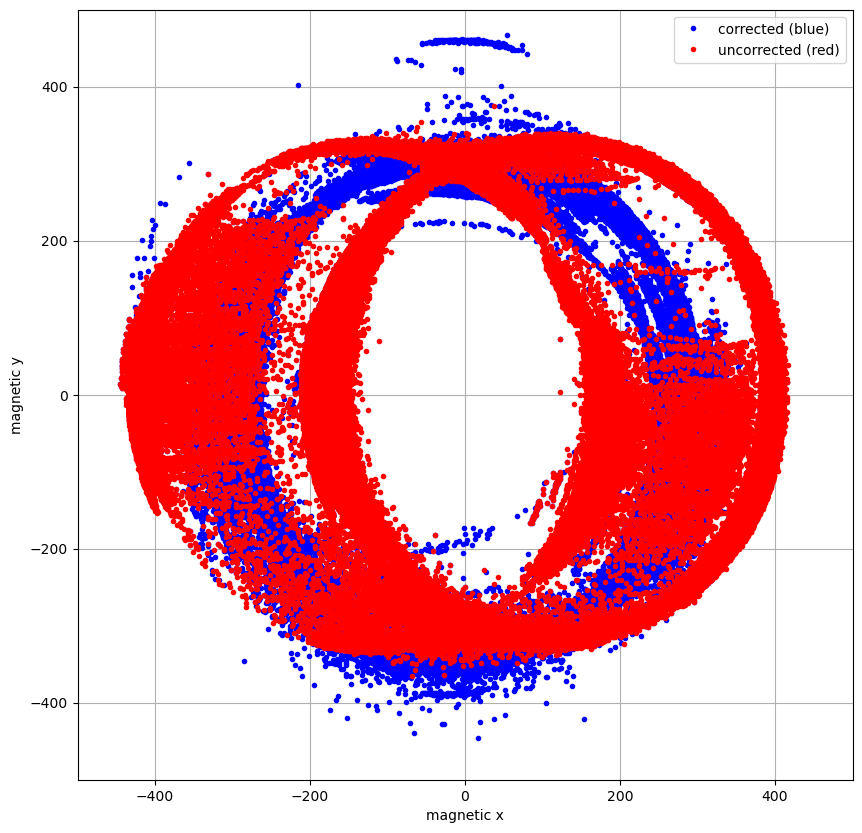

In [9]:
# heading correction
plt.figure(figsize=(10,10))
plt.plot(tot_ad2cp.MagX_corrected, tot_ad2cp.MagY_corrected, '.b',tot_ad2cp.MagnetometerX,tot_ad2cp.MagnetometerY, '.r')
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.grid()
plt.legend([ 'corrected (blue)','uncorrected (red)'])
plt.xlabel('magnetic x')
plt.ylabel('magnetic y')
plt.show()

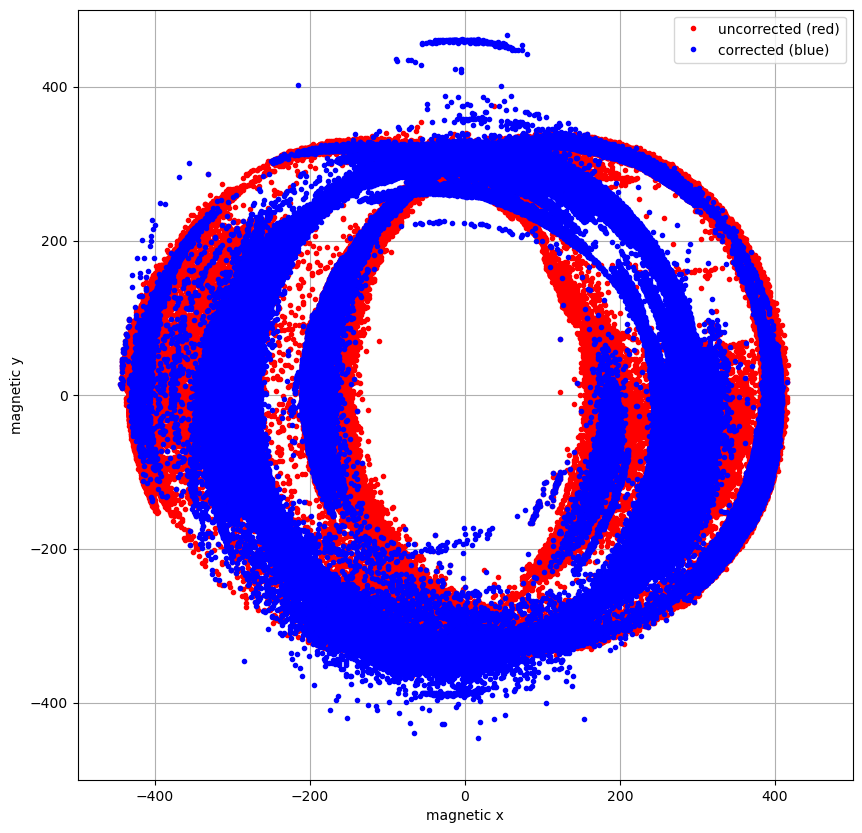

In [10]:
# heading correction
plt.figure(figsize=(10,10))
plt.plot(tot_ad2cp.MagnetometerX,tot_ad2cp.MagnetometerY, '.r',tot_ad2cp.MagX_corrected, tot_ad2cp.MagY_corrected, '.b')
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.grid()
plt.legend(['uncorrected (red)', 'corrected (blue)'])
plt.xlabel('magnetic x')
plt.ylabel('magnetic y')
plt.show()

## Step 4: Subset datasets (for testing)
Pull out just one glider segment (based on a unique file name) and the corresponding dead-reckoned depth average current. Use the start and end times to subset the AD2CP data

In [19]:
x=101

## Subset glider df to one segment
subsetgdf = gdf[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])]
## Pull out last non-NaN DAC
## Subset glider df to one segment
subsetgdf = gdf[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])]
## Pull out last non-NaN DAC
ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()
vx          = subsetgdf.m_water_vx.iloc[ind[-1]]
vy          = subsetgdf.m_water_vy.iloc[ind[-1]]
mag_var     = np.nanmean(subsetgdf.m_gps_mag_var)
print(vx)
print(vy)
print(mag_var )

## Subset AD2CP dataframe based on segment start and end times
ad2cp_time_ind = np.where((tot_ad2cp.time >= start_times2[x]) & (tot_ad2cp.time <= end_times2[x]))[0]
subset_ad2cp = tot_ad2cp.sel(time=tot_ad2cp.time[ad2cp_time_ind])

-0.00896732
-0.0592632
11.59998892865962


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_17155/1806289003.py:9: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


## Step 5: Correct for the local magnetic declination

In [ ]:
heading_cor_mag_var,vx_cor,vy_cor= slocum_ad2cp.mag_var_correction(subset_ad2cp['CorrectedHeading'].values,vx,vy,mag_var)

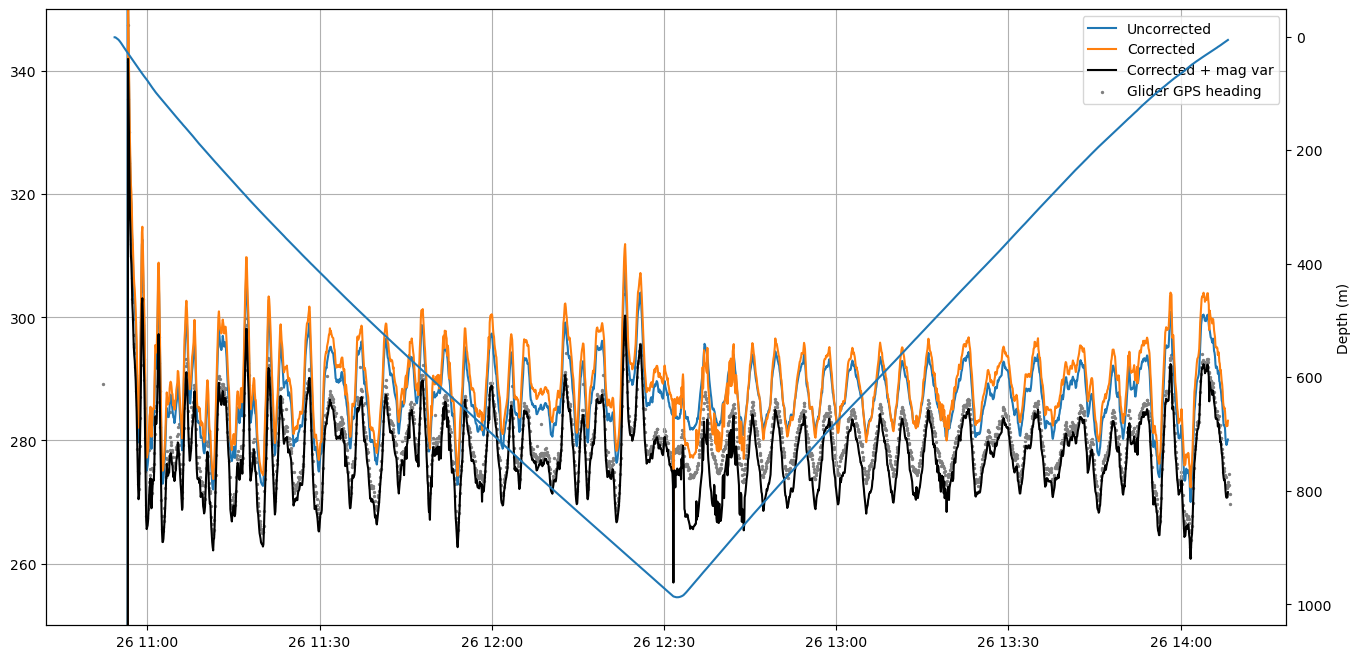

In [46]:
plt.figure(figsize=(16,8))
plt.plot(subset_ad2cp.time,subset_ad2cp.Heading,label='Uncorrected')
plt.plot(subset_ad2cp.time,subset_ad2cp.CorrectedHeading,label='Corrected')
plt.plot(subset_ad2cp.time,heading_cor_mag_var,color='black',label='Corrected + mag var')
plt.scatter(pd.to_datetime(subsetgdf.time),subsetgdf.m_heading,color='gray',s=2,label='Glider GPS heading')
plt.ylim(250,350)
plt.grid()
plt.legend()

ax2 = plt.twinx()
ax2.plot(subset_ad2cp.time,subset_ad2cp.Depth)
ax2.set_ylabel('Depth (m)')
ax2.invert_yaxis()

## Take a quick peak at some data

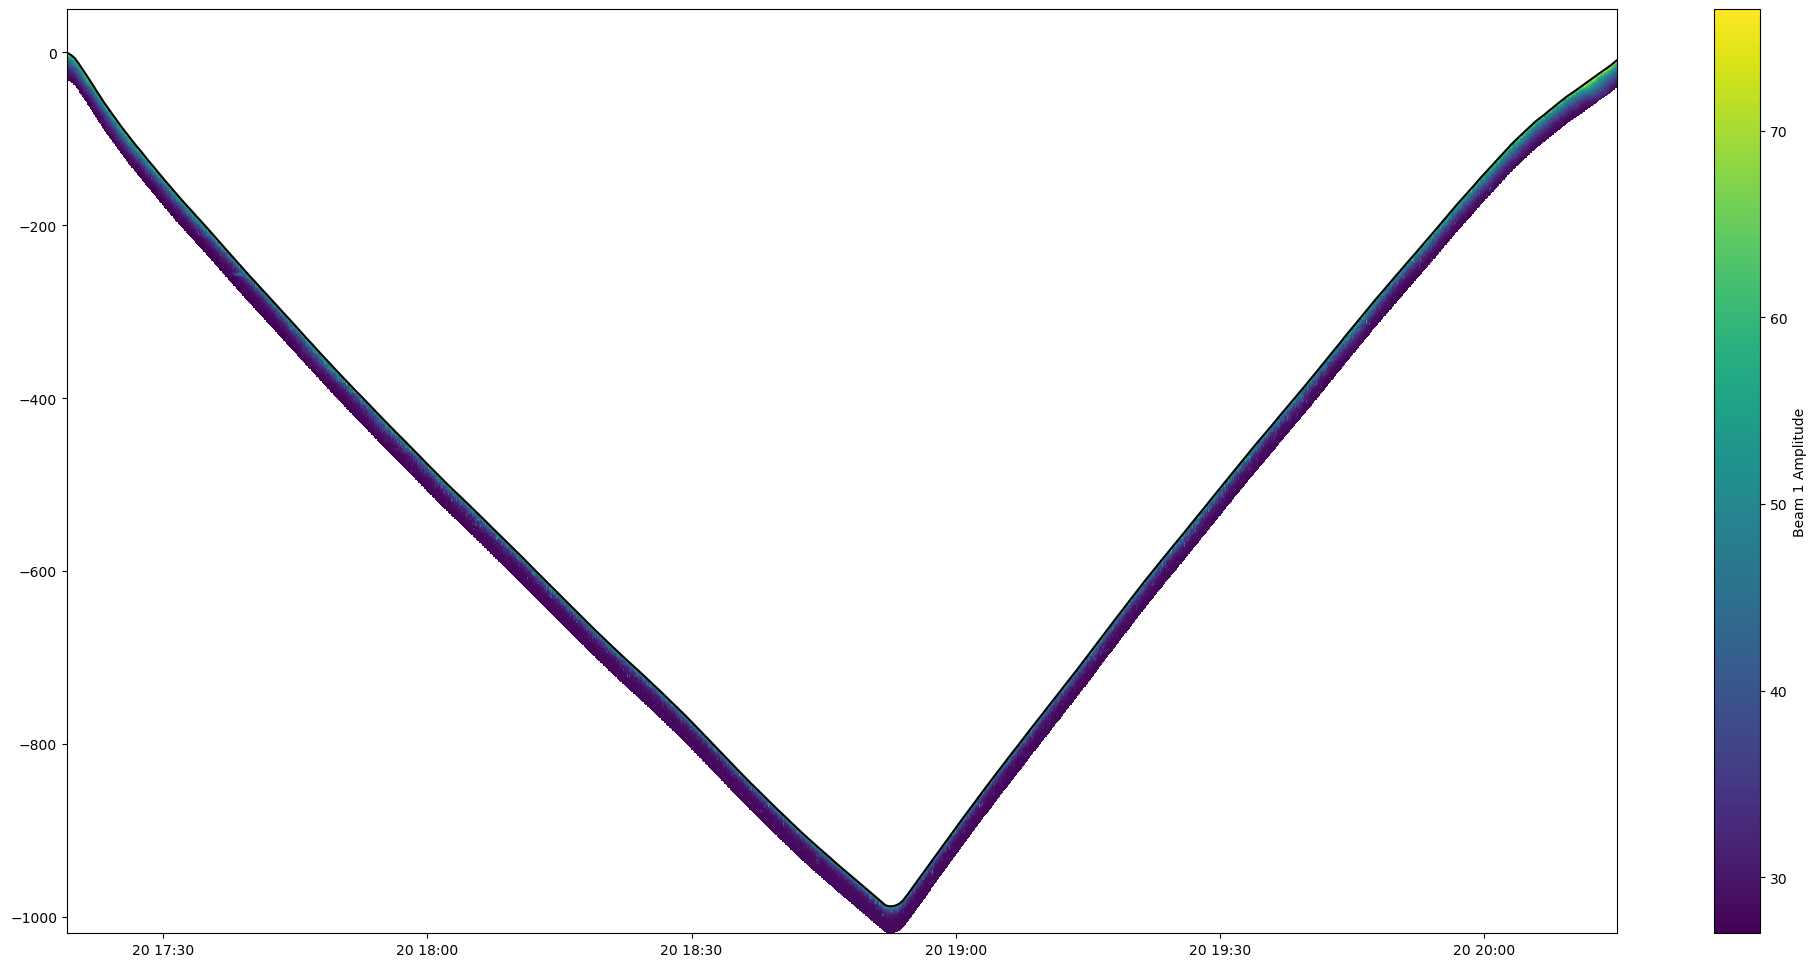

In [12]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Depth'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x,-by,subset_ad2cp['AmplitudeBeam1'])
plt.plot(subset_ad2cp['time'],-subset_ad2cp['Depth'],'k')
plt.colorbar(label='Beam 1 Amplitude')


### Zoomed in peak at data

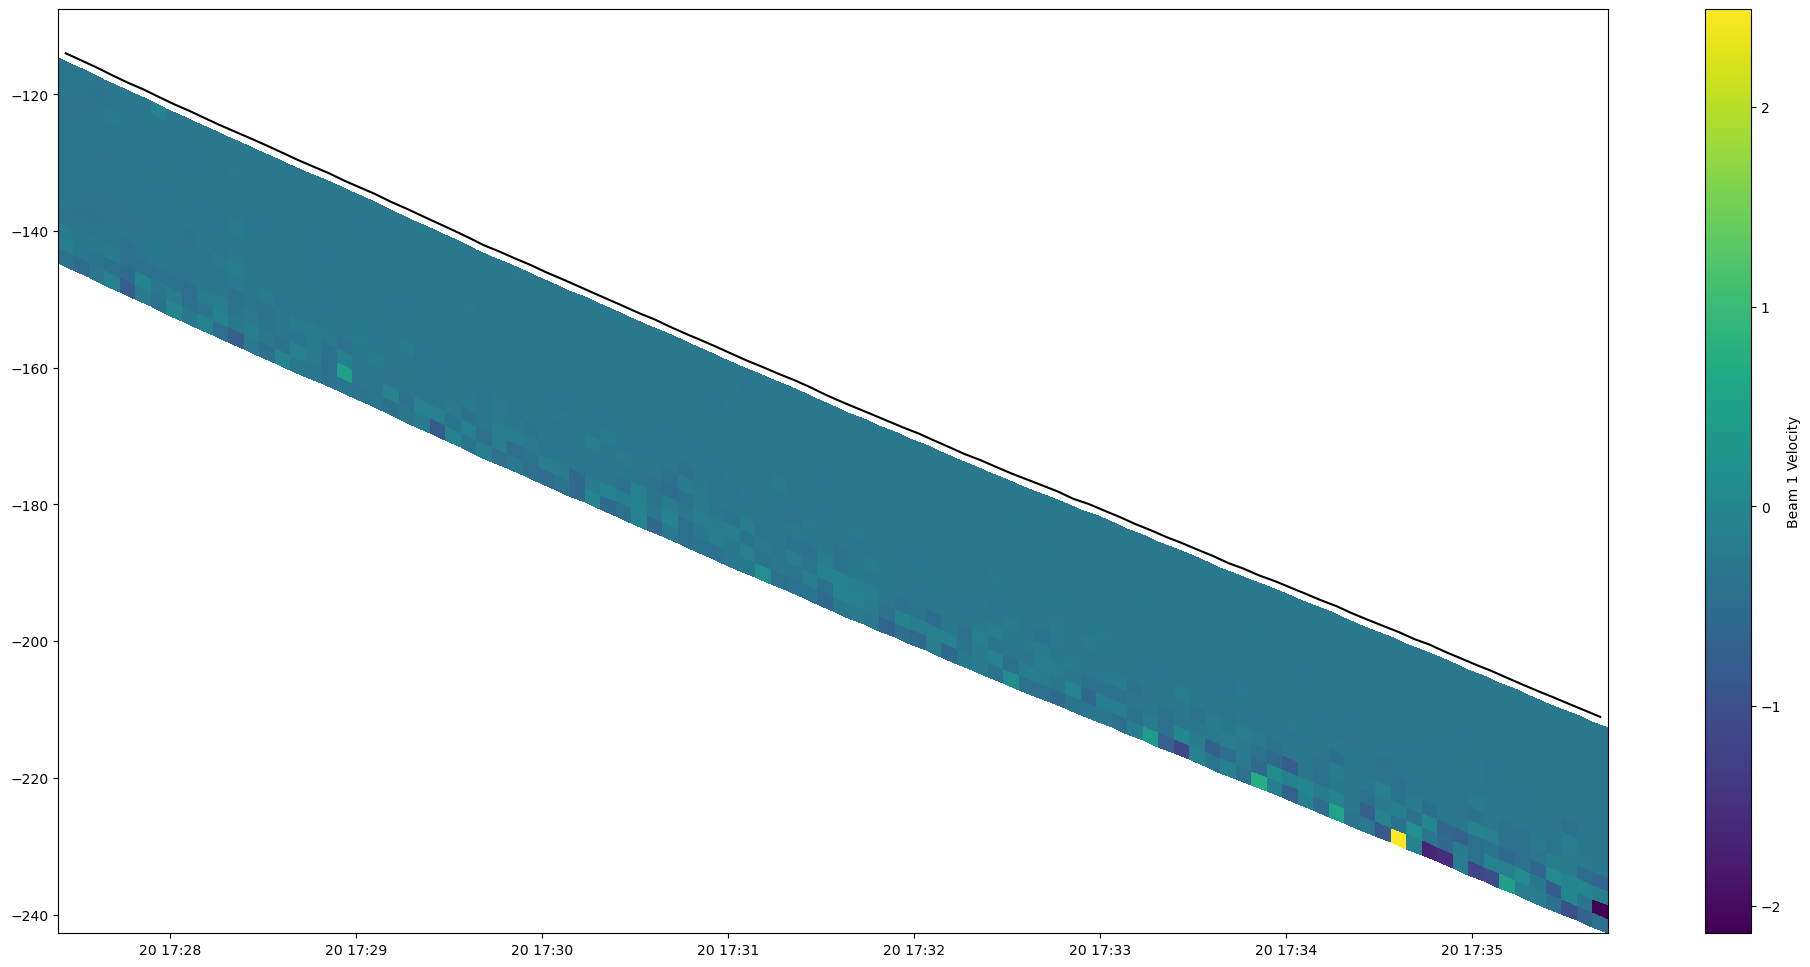

In [13]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Depth'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 100
end_ind   = 200

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Depth'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Velocity')


## Step 4: Correct for local speed of sound (Fischer and Visbeck, 1993)
Where C is the real sound speed at the transducer, and CA is the speed of sound used by the ADCP. CA used by the Nortek AD2CP is 1500 m/s.

In [14]:
np.max(subset_ad2cp.VelocityBeam1.values)

np.float32(3.217)

In [15]:
# Correct for local speed of sound
subset_ad2cp = slocum_ad2cp.correct_sound_speed(subset_ad2cp)

In [16]:
np.max(subset_ad2cp.VelocityBeam1.values)

np.float32(3.197698)

### Take a peak at the speed of sound corrected data

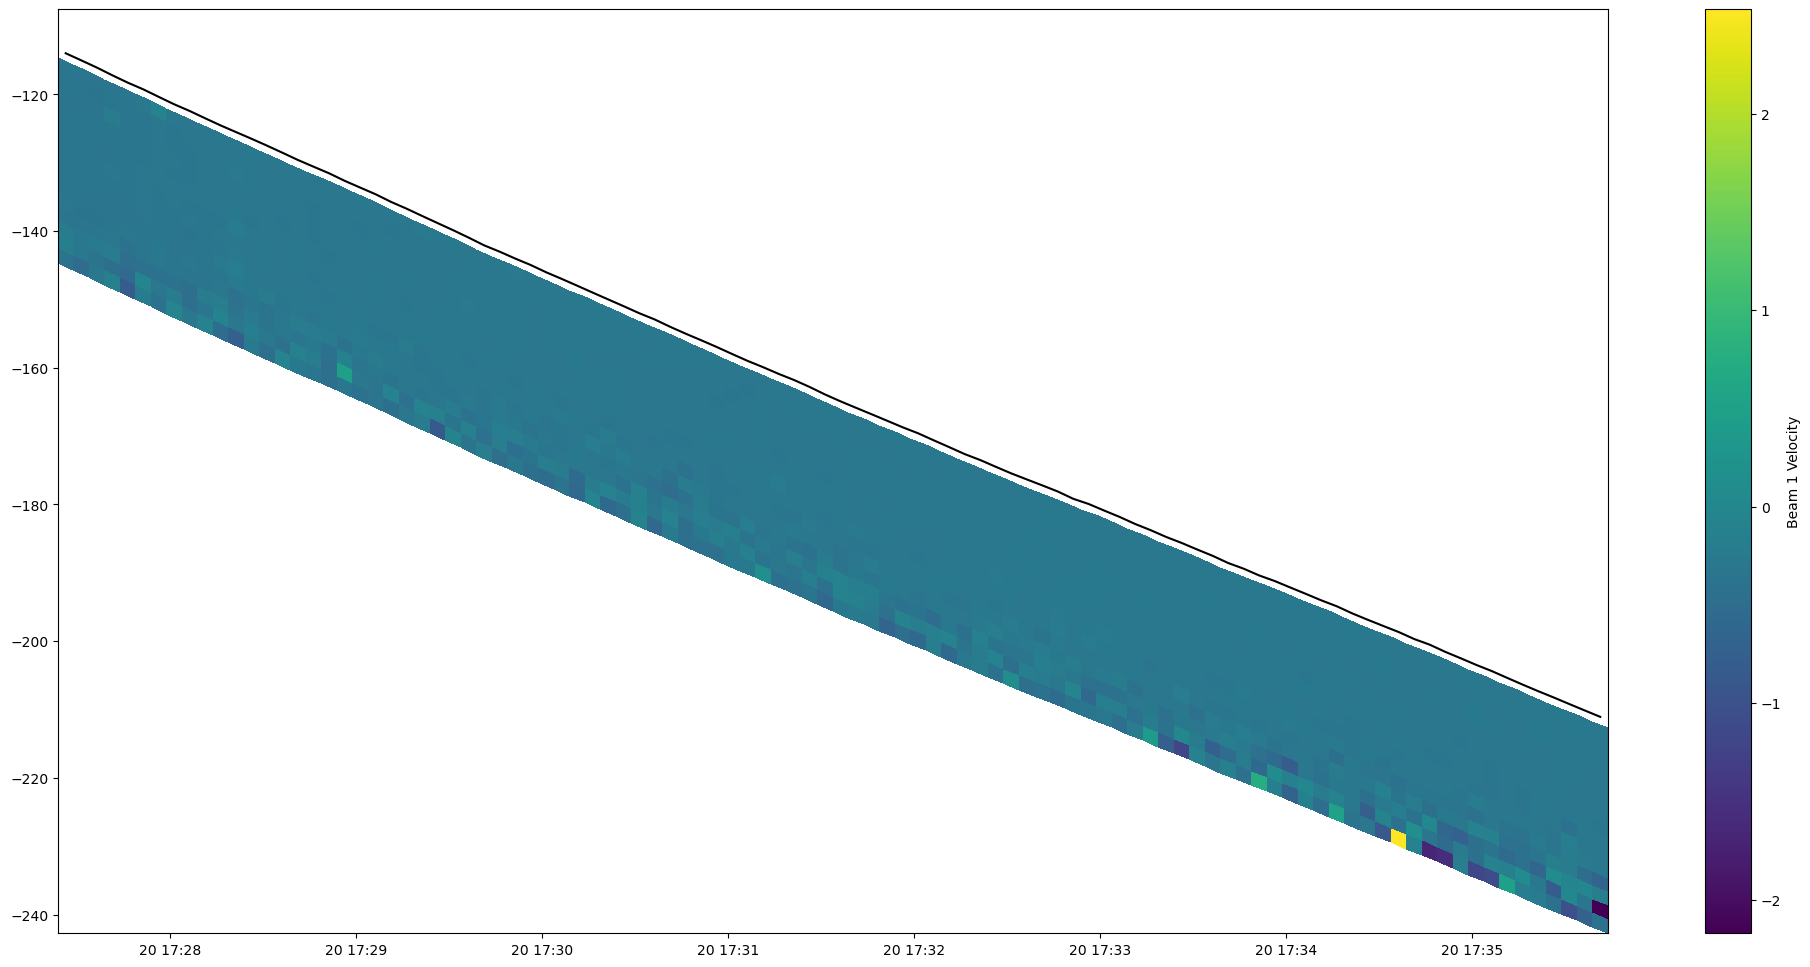

In [17]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Depth'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 100
end_ind   = 200

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Depth'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Velocity')


## Step 5: Filter for Extreme Amplitude Returns and Below 0.5 Correlation (Todd et al. 2017)

In [18]:
np.nanmean(subset_ad2cp.VelocityBeam1.values)

np.float32(-0.2773972)

In [19]:
## QAQC pre-coordinate transformation
subset_ad2cp = slocum_ad2cp.qaqc_pre_coord_transform(subset_ad2cp, corr_threshold = 50, max_amplitude = 75)

In [20]:
np.nanmean(subset_ad2cp.VelocityBeam1.values)

np.float32(-0.28612816)

### Take a peak at the QAQC'd data

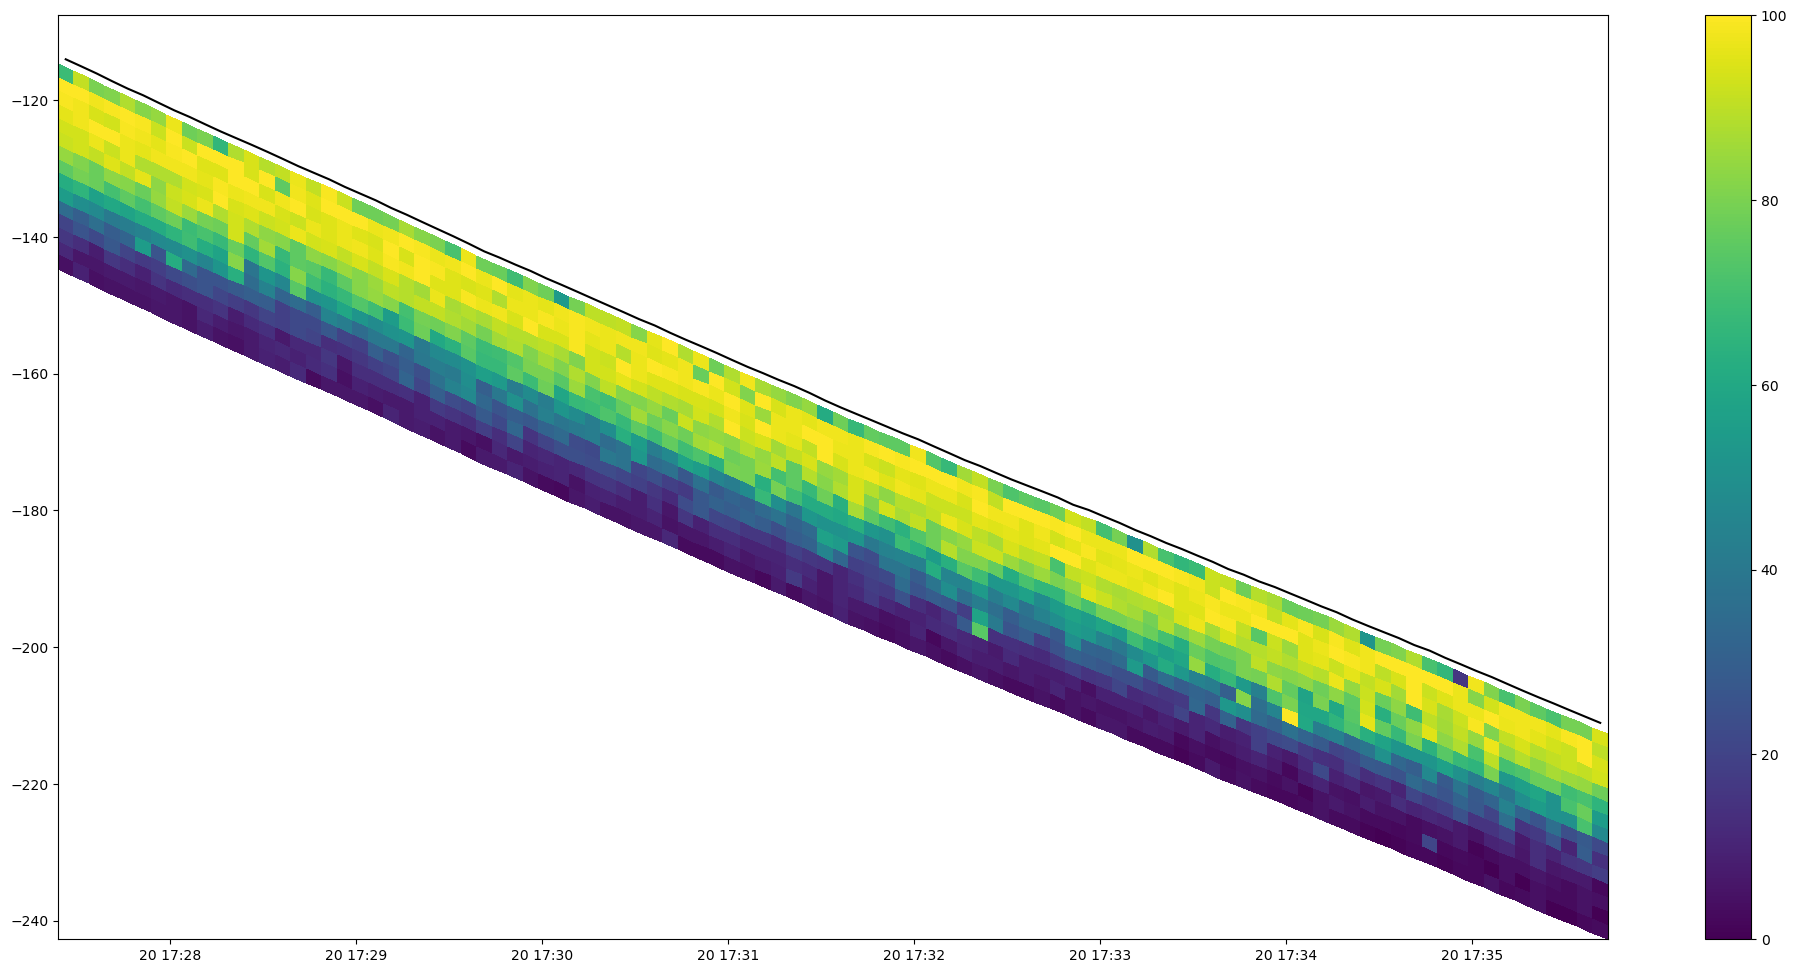

In [21]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Depth'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 100
end_ind   = 200


fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['CorrelationBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Depth'][start_ind:end_ind],'k')
plt.colorbar()
#plt.colorbar(label='Beam 1 Correlation')


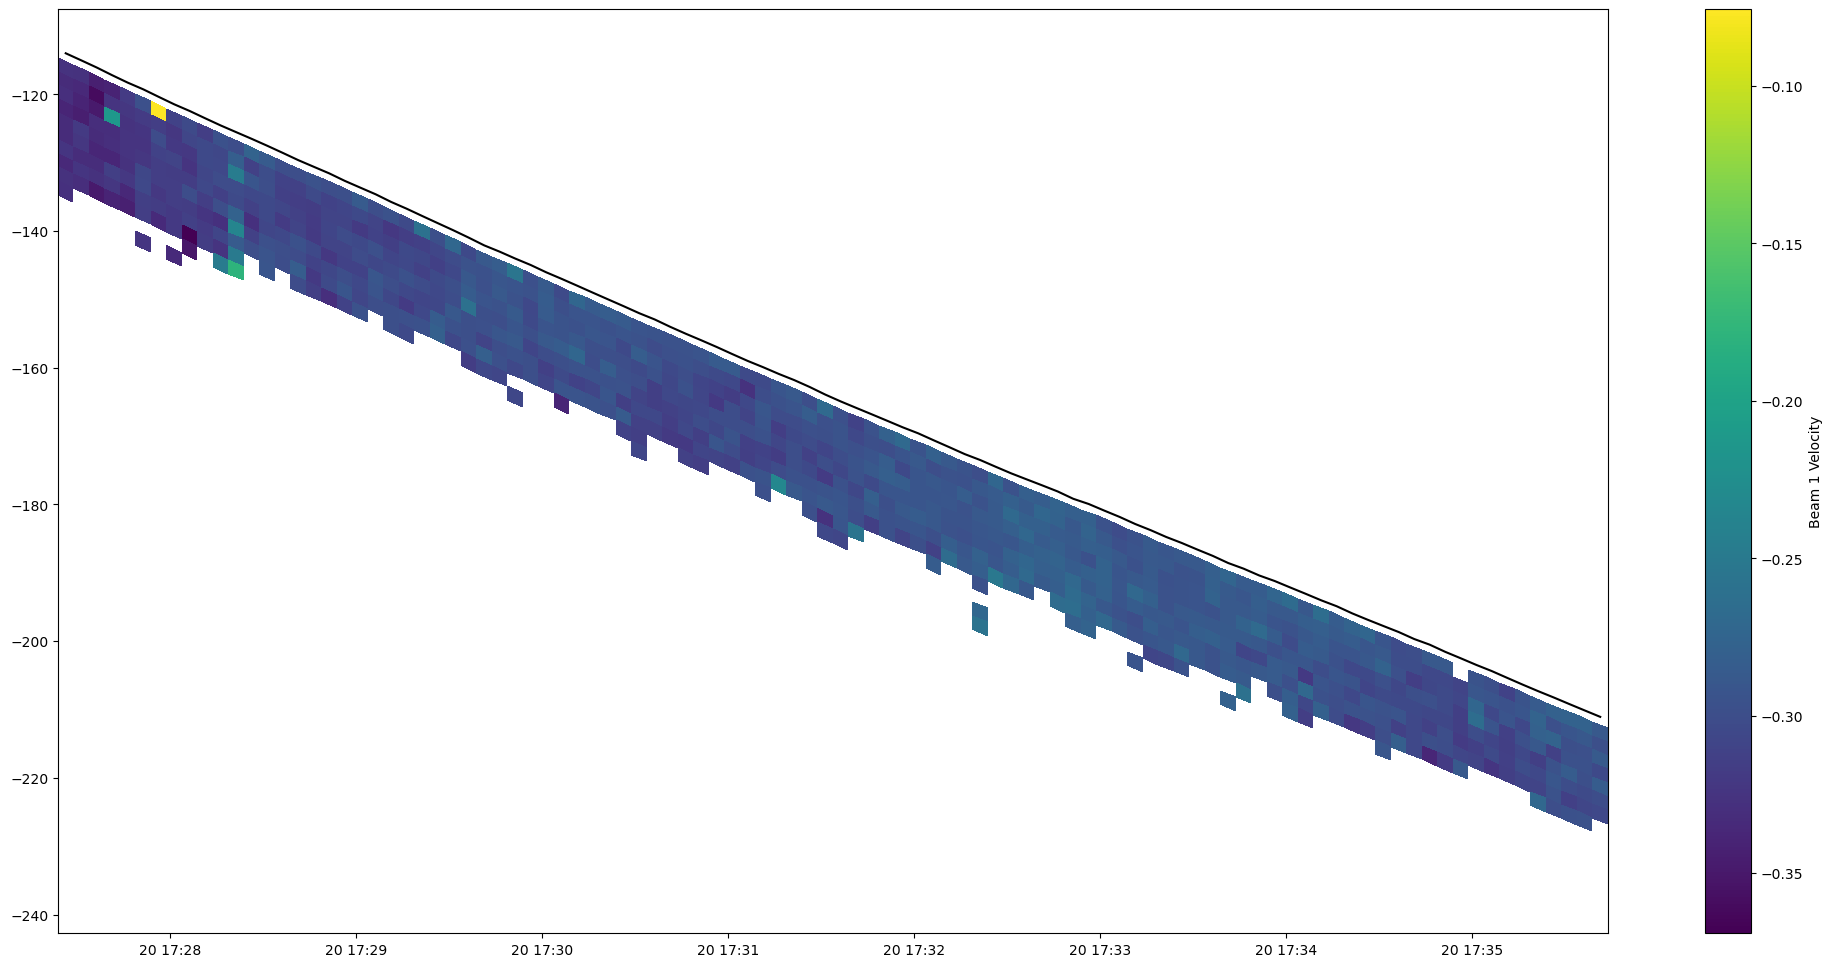

In [22]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Depth'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 100
end_ind   = 200

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Depth'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Velocity')


## Processing Step 6: Correct beams to level true-depth

In [23]:
## Correct beams to level true-depth
subset_ad2cp = slocum_ad2cp.beam_true_depth(subset_ad2cp)

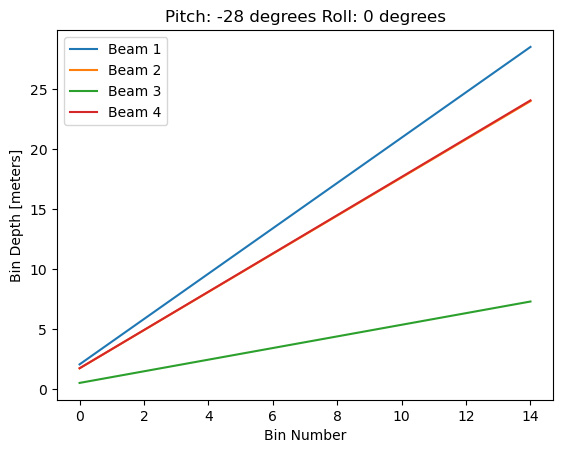

In [24]:
x=20
plt.plot(subset_ad2cp.TrueDepthBeam1.values[:,x],label='Beam 1')
plt.plot(subset_ad2cp.TrueDepthBeam2.values[:,x],label='Beam 2')
plt.plot(subset_ad2cp.TrueDepthBeam3.values[:,x],label='Beam 3')
plt.plot(subset_ad2cp.TrueDepthBeam4.values[:,x],label='Beam 4')
plt.ylabel('Bin Depth [meters]')
plt.xlabel('Bin Number')
plt.title('Pitch: %i' %subset_ad2cp['Pitch'].values[x] + ' degrees Roll: %i' %subset_ad2cp['Roll'].values[x] + ' degrees')
plt.legend()

## Processing Step 7: Bin Mapping
Interpolate to set depth grid, this will also effectively filter out extreme pitch and roll

In [25]:
## Bin map
subset_ad2cp = slocum_ad2cp.binmap_adcp(subset_ad2cp)

In [26]:
subset_ad2cp

<xarray.Dataset> Size: 4MB
Dimensions:                    (VelocityRange: 15, time: 2112,
                                CorrelationRange: 15, AmplitudeRange: 15,
                                Physicalbeam_dim: 4)
Coordinates:
  * time                       (time) datetime64[ns] 17kB 2024-04-20T17:19:06...
  * VelocityRange              (VelocityRange) float32 60B 2.2 4.2 ... 28.2 30.2
  * CorrelationRange           (CorrelationRange) float32 60B 2.2 4.2 ... 30.2
  * AmplitudeRange             (AmplitudeRange) float32 60B 2.2 4.2 ... 30.2
Dimensions without coordinates: Physicalbeam_dim
Data variables: (12/55)
    VelocityBeam1              (VelocityRange, time) float32 127kB 0.06794 .....
    VelocityBeam2              (VelocityRange, time) float32 127kB -0.1029 .....
    VelocityBeam3              (VelocityRange, time) float32 127kB -0.176 ......
    VelocityBeam4              (VelocityRange, time) float32 127kB -0.1246 .....
    CorrelationBeam1           (CorrelationRange, time) float32 127kB dask.array<chunksize=(15, 2112), meta=np.ndarray>
    CorrelationBeam2           (CorrelationRange, time) float32 127kB dask.array<chunksize=(15, 2112), meta=np.ndarray>
    ...                         ...
    TrueDepthBeam4             (VelocityRange, time) float64 253kB 1.995 ... ...
    TrueDepth                  (VelocityRange, time) float64 253kB 3.284 ... ...
    InterpVelocityBeam1        (VelocityRange, time) float64 253kB 0.0763 ......
    InterpVelocityBeam2        (VelocityRange, time) float64 253kB -0.1081 .....
    InterpVelocityBeam3        (VelocityRange, time) float64 253kB -0.2122 .....
    InterpVelocityBeam4        (VelocityRange, time) float64 253kB -0.1352 .....
Attributes: (12/350)
    instrumentOffsetTimeMatlab_description:       Offset from instrument time...
    File_ins_runTime:                             442996000.0
    File_ins_runTime_description:                 Length of time data was col...
    File_ins_name:                                AD2CPRaw
    File_ins_name_description:                    Name of instrument
    File_ins_typeName:                            
    ...                                           ...
    instrumentOffsetTime:                         0.0
    instrumentOffsetTime_description:             Offset from instrument time...
    timeZoneOffset:                               0
    timeZoneOffset_description:                   Offset of platform local ti...
    instrumentOffsetTimeMatlab:                   0.0
    exportRevision:                               4489

### Take a peak at the bin mapped data

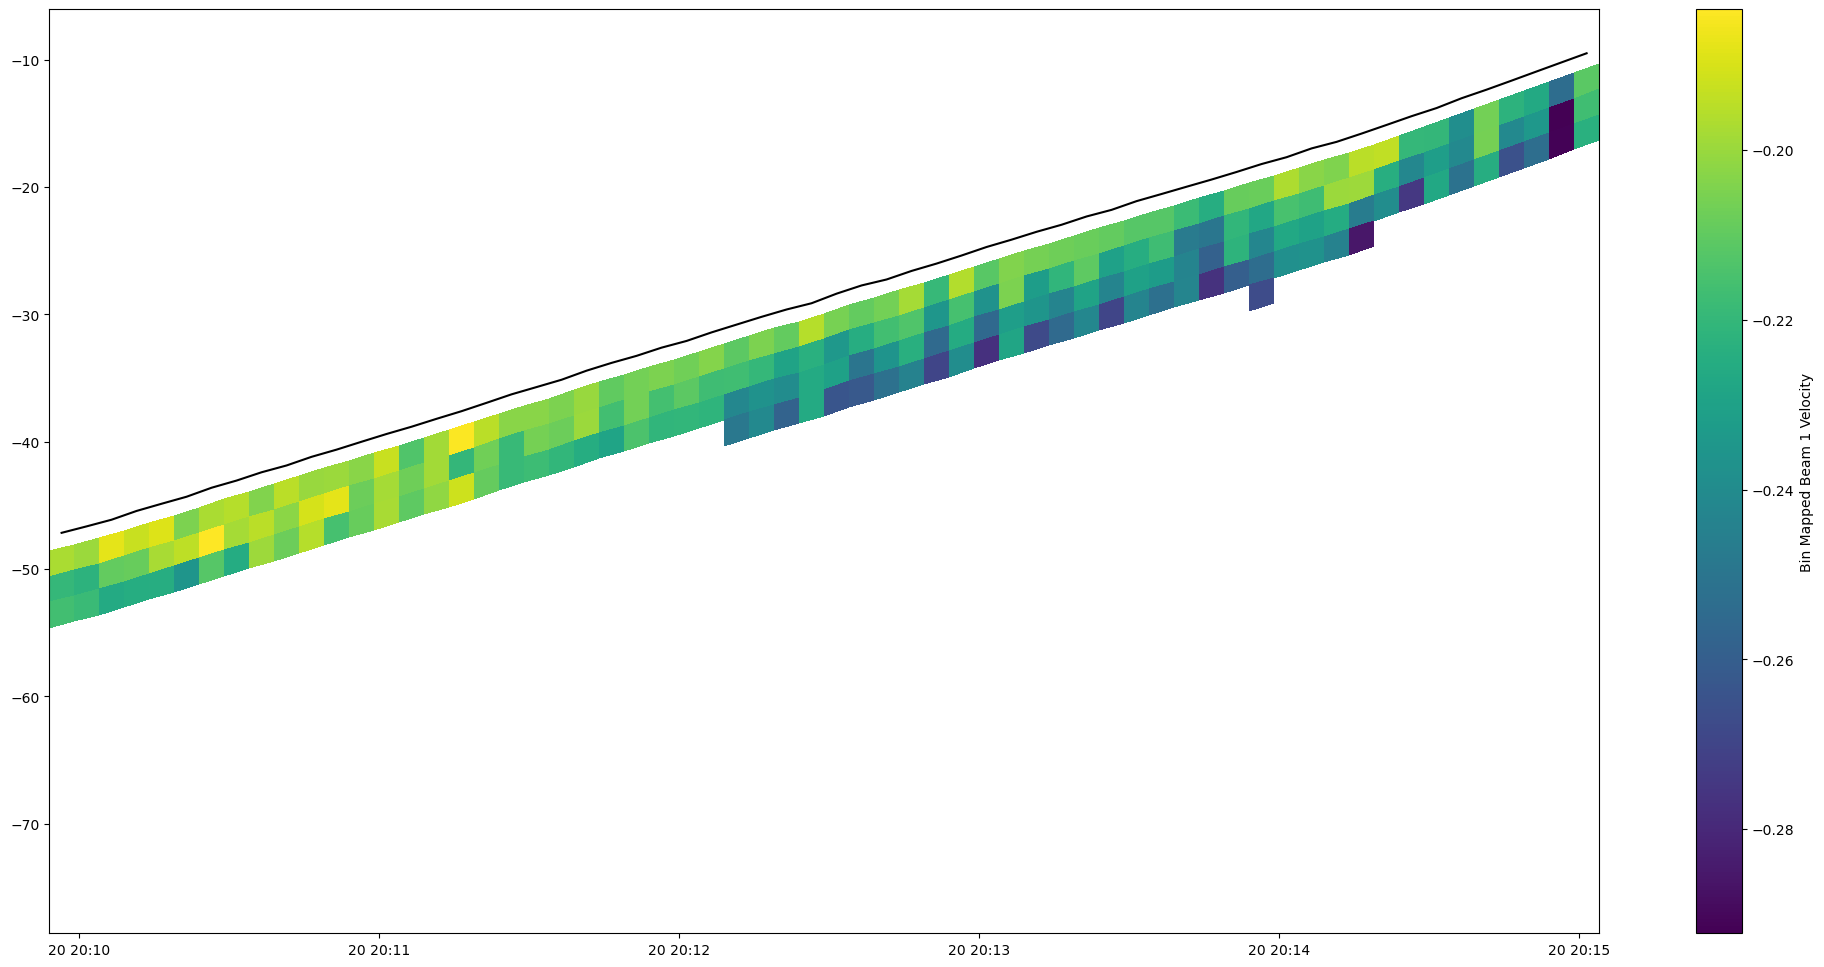

In [27]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Depth'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 100
end_ind   = 200

start_ind = 2050
end_ind   = 2400

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['InterpVelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Depth'][start_ind:end_ind],'k')
plt.colorbar(label='Bin Mapped Beam 1 Velocity')


## Processing Step 8: Correct heading for local magnetic delcination and local magnetic field

In [28]:
subset_ad2cp = slocum_ad2cp.calcAHRS(subset_ad2cp)


## Processing Step 9: Convert from Beam to XYZ to ENU coordinates

In [29]:
## Beam to ENU
subset_ad2cp = slocum_ad2cp.beam2enu(subset_ad2cp)

### Take a peak at ENU data

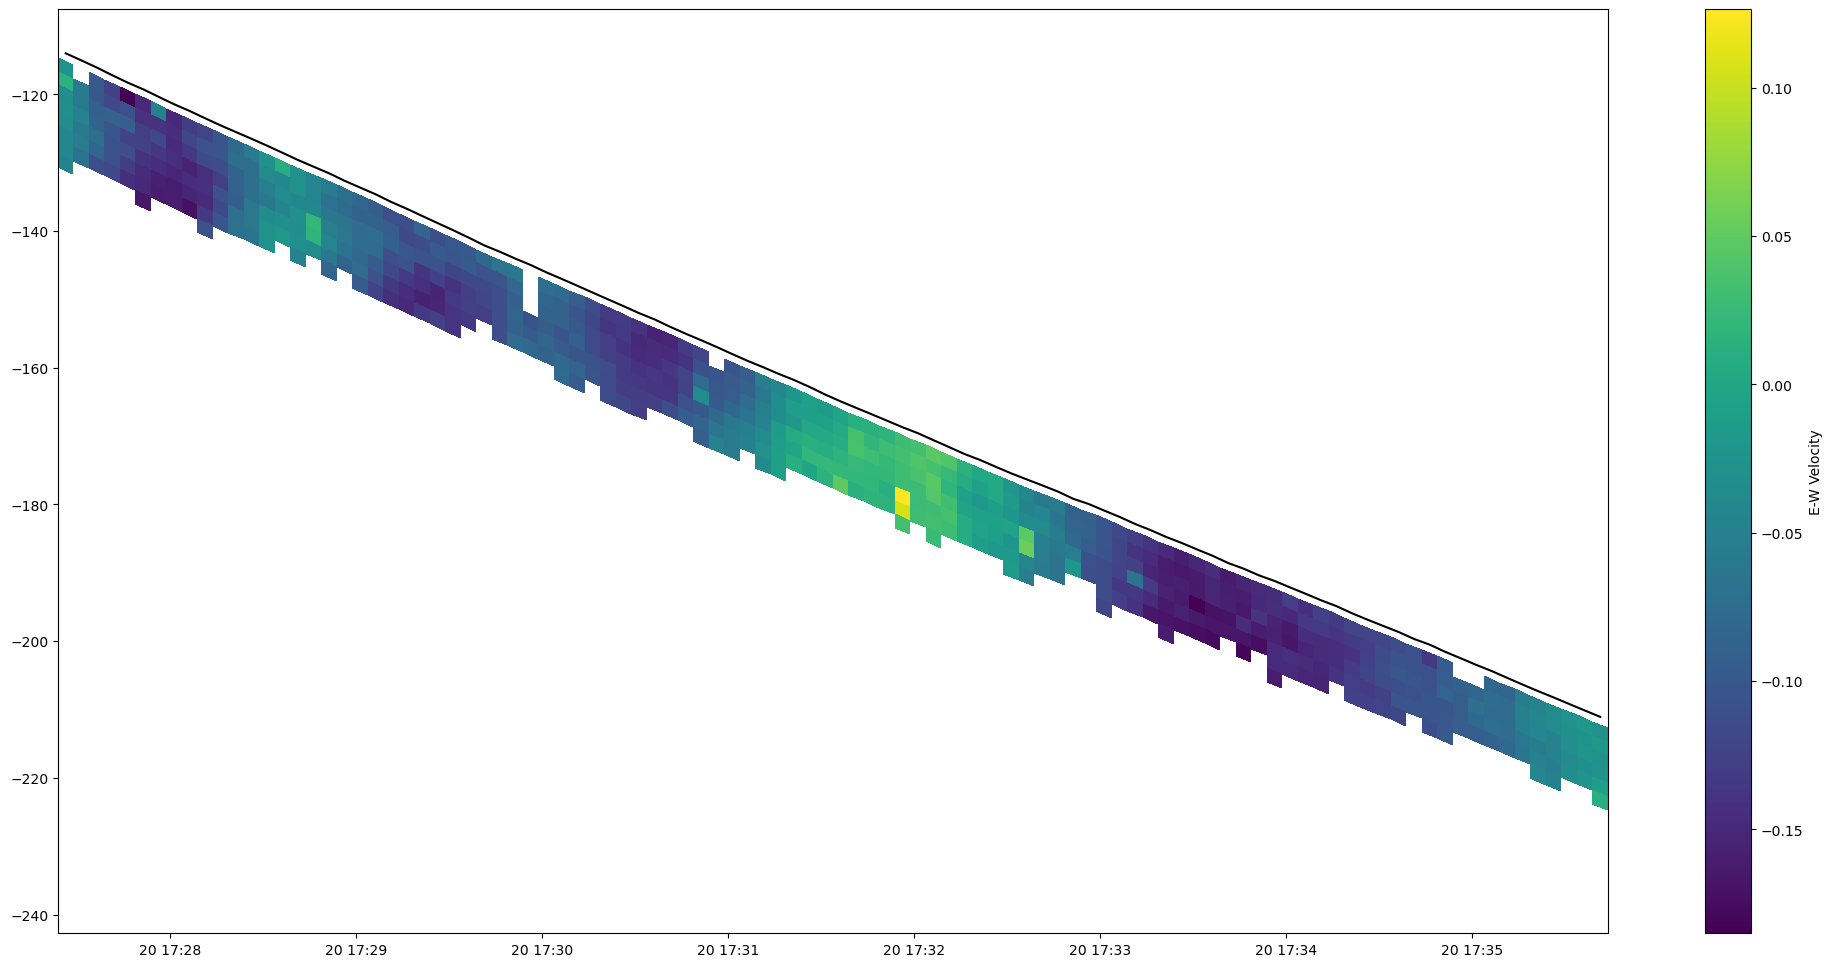

In [30]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Depth'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 100
end_ind   = 200


fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['UVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Depth'][start_ind:end_ind],'k')
plt.colorbar(label='E-W Velocity')


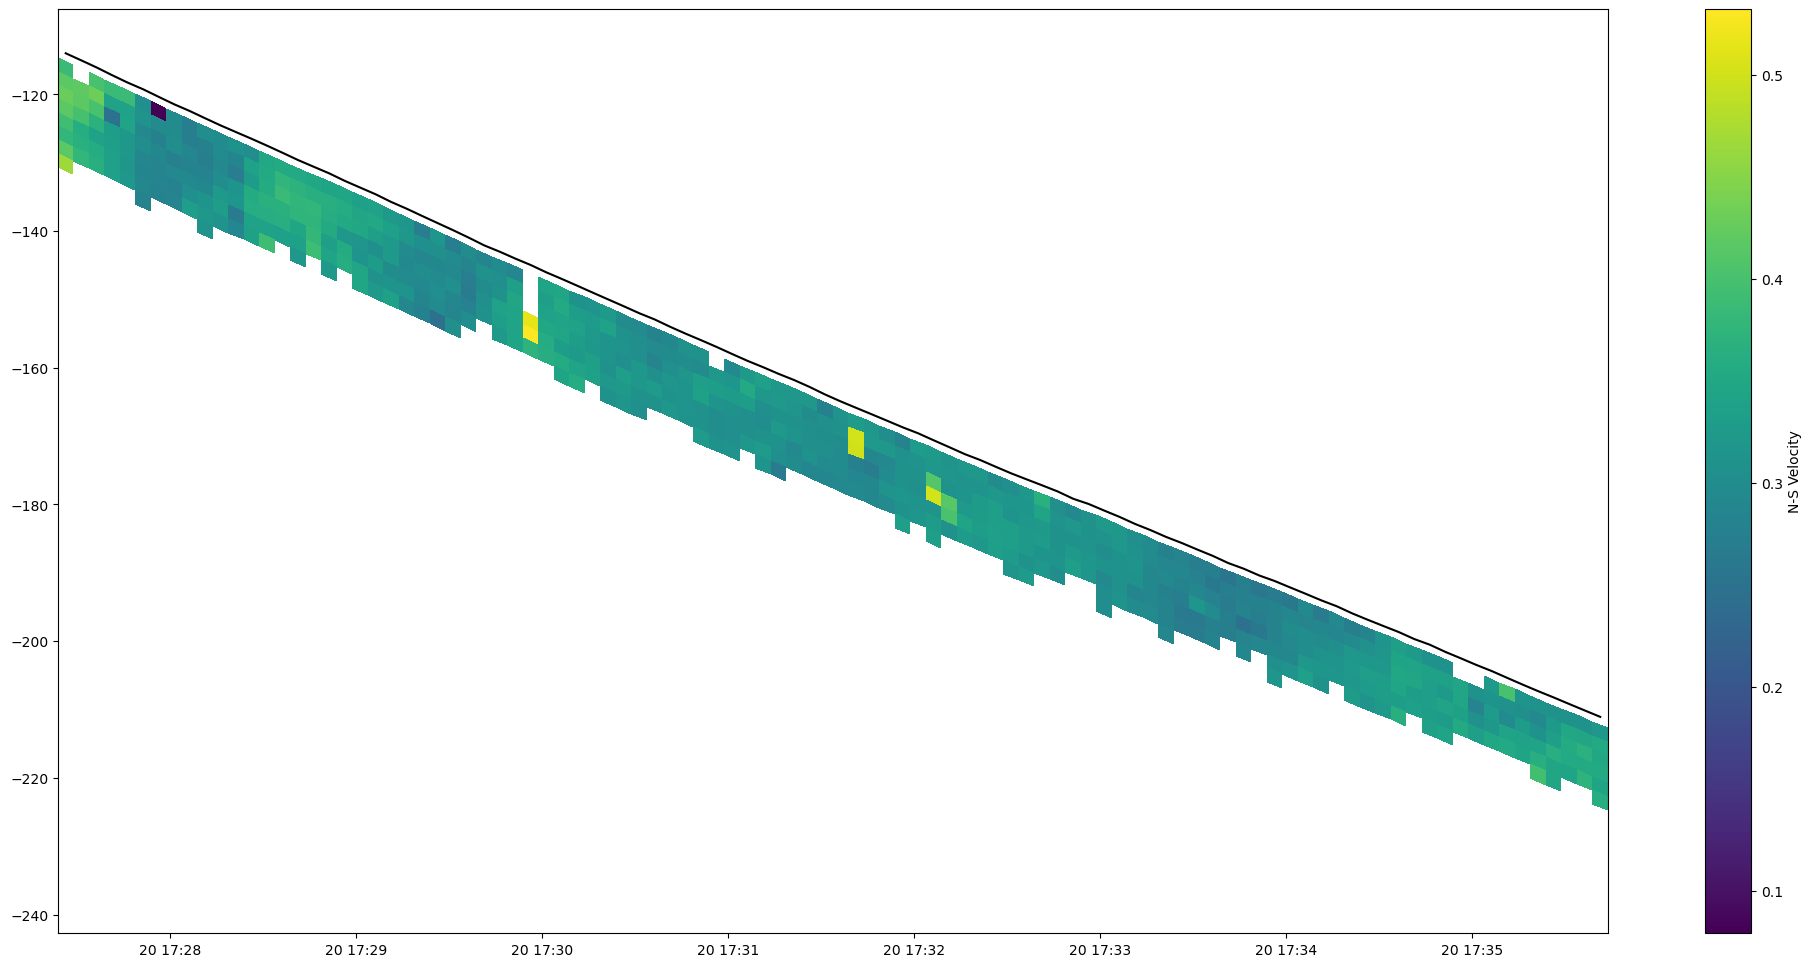

In [31]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Depth'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 100
end_ind   = 200


fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Depth'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')


## Filter out really high velocities relative to glider and first bin below glider

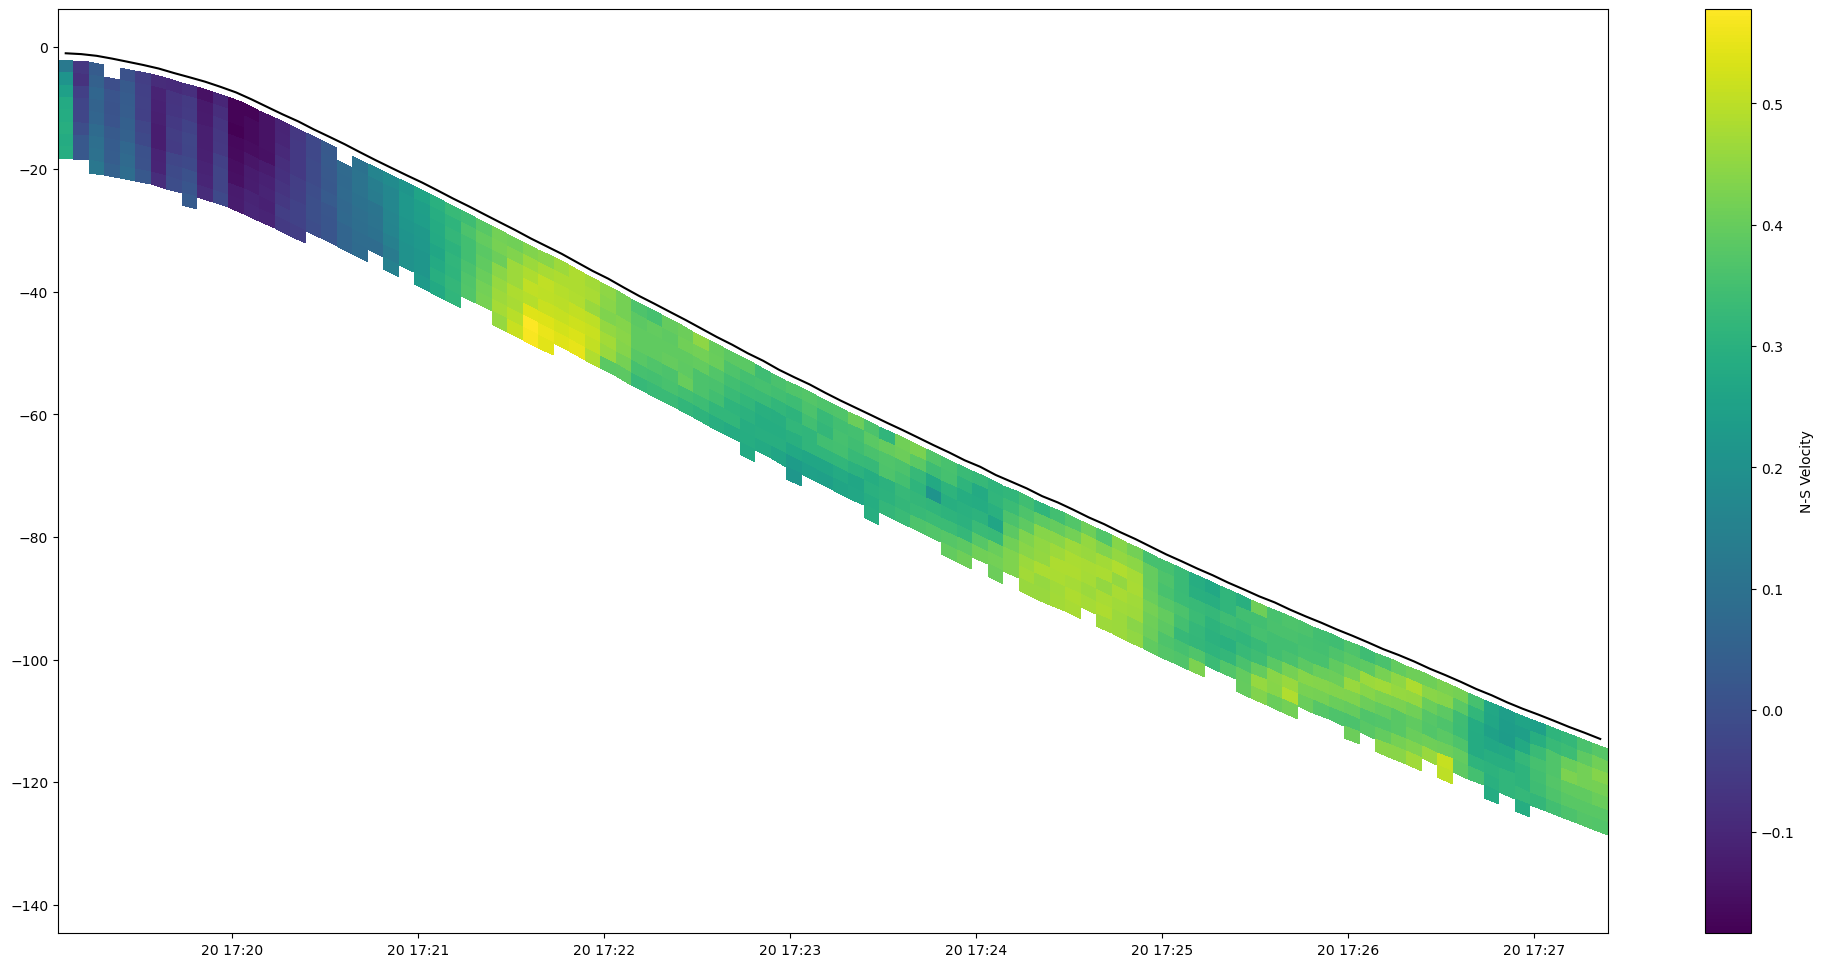

In [32]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Depth'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 0
end_ind   = 100

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Depth'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')


In [33]:
subset_ad2cp = slocum_ad2cp.qaqc_post_coord_transform(subset_ad2cp, high_velocity_threshold=0.75, surface_depth_to_filter = 5)

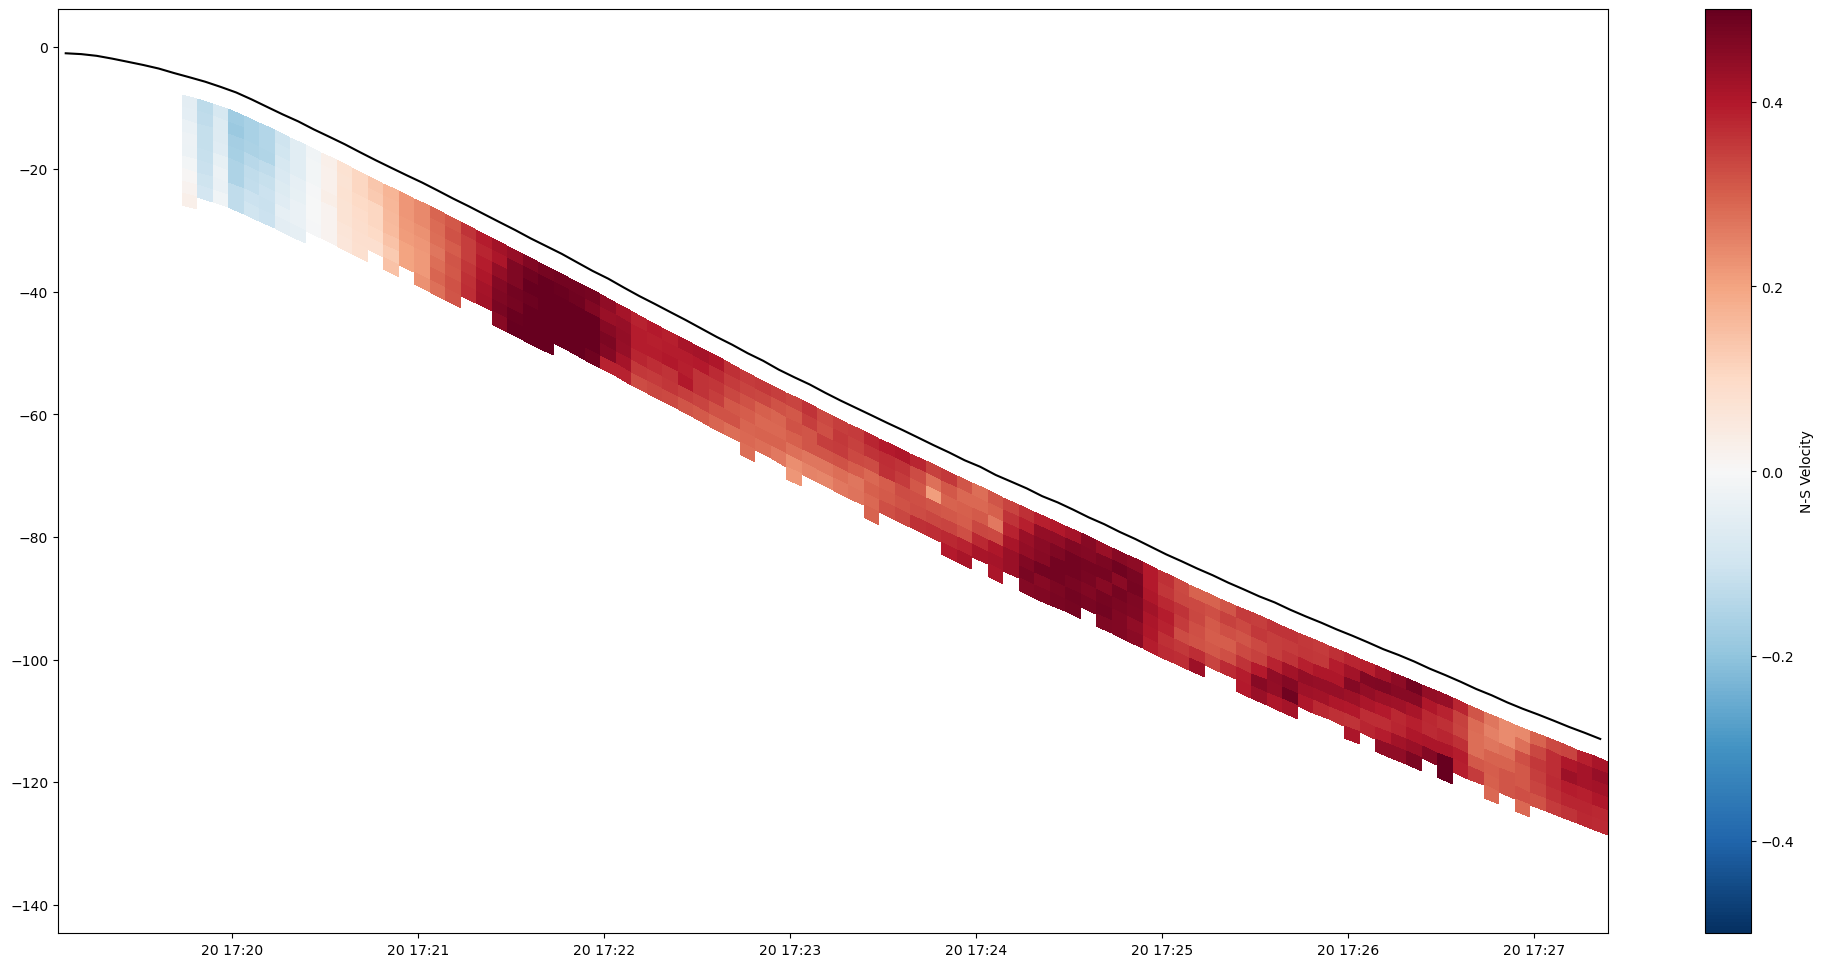

In [45]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Depth'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins


start_ind = 0
end_ind   = 100


fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind],vmin=-0.5,vmax=0.5,cmap='RdBu_r')
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Depth'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')


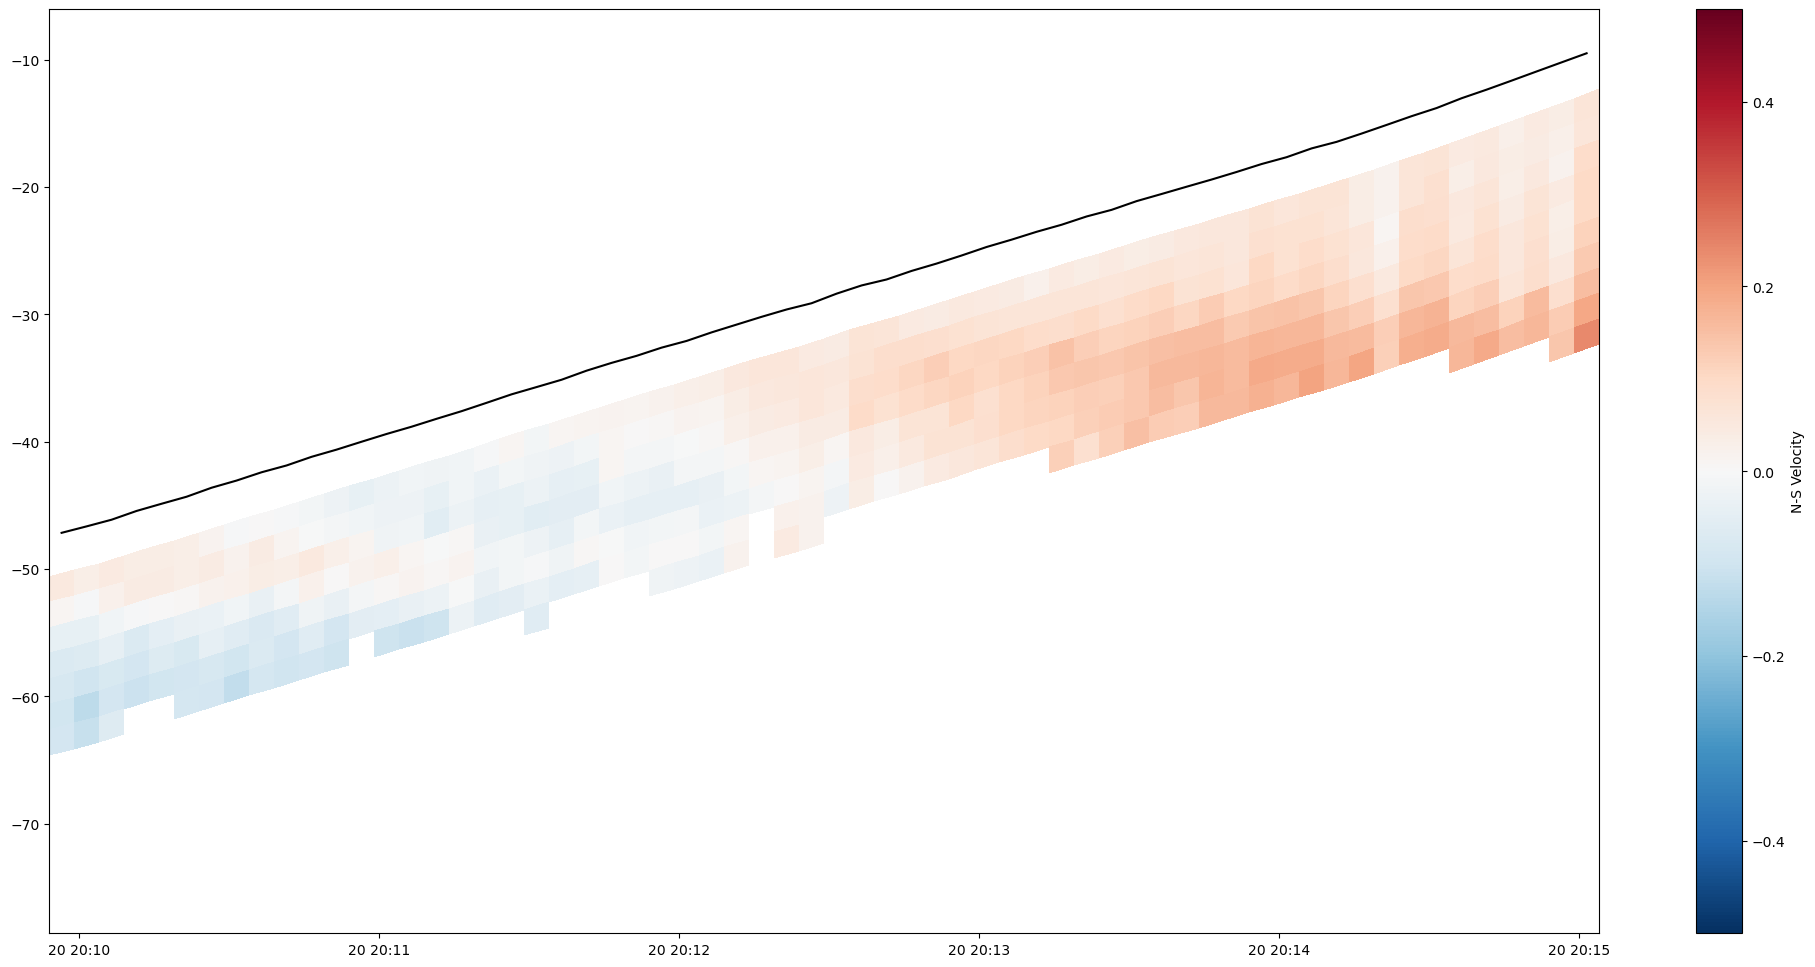

In [46]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Depth'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 2050
end_ind   = 2400


fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind],vmin=-0.5,vmax=0.5,cmap='RdBu_r')
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Depth'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')


## Processing Step 9: Run the inversion!

In [41]:
dz=5
wDAC = 5
wSmoothness = 1


O_ls, G_ls, bin_new, obs_per_bin = slocum_ad2cp.inversion(subset_ad2cp.UVelocity.values,subset_ad2cp.VVelocity.values,
          dz,vx,vy,subset_ad2cp['VelocityRange'].values,subset_ad2cp['Depth'].values, wDAC, wSmoothness)

Text(0.5, 0, 'Velocity [m/s]')

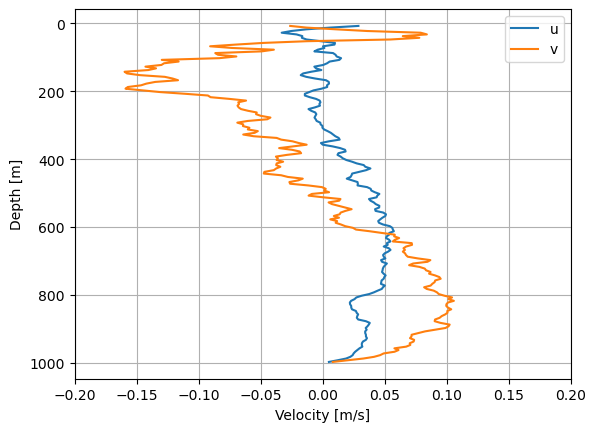

In [42]:
plt.plot(np.real(O_ls),bin_new,label='u')
plt.plot(np.imag(O_ls),bin_new,label='v')
plt.gca().invert_yaxis()
plt.xlim(-0.2,0.2)
plt.legend()
plt.grid()
plt.ylabel('Depth [m]')
plt.xlabel('Velocity [m/s]')